In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


## Data

In [2]:
# The dataset contained n = 41266 minutes of data ranging 
# from April to August 2017 on 500 stocks as well as the total S&P 500 index price

data = pd.read_csv('data_stocks.csv')
data.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


In [3]:
# Drop date variable
data = data.drop(['DATE'], 1)

In [4]:
# Dimensions of dataset
n = data.shape[0]
p = data.shape[1]

print (n)
print (p)

# Make data a numpy array
data = data.values

# the data is already cleaned, no misssing values 

41266
501


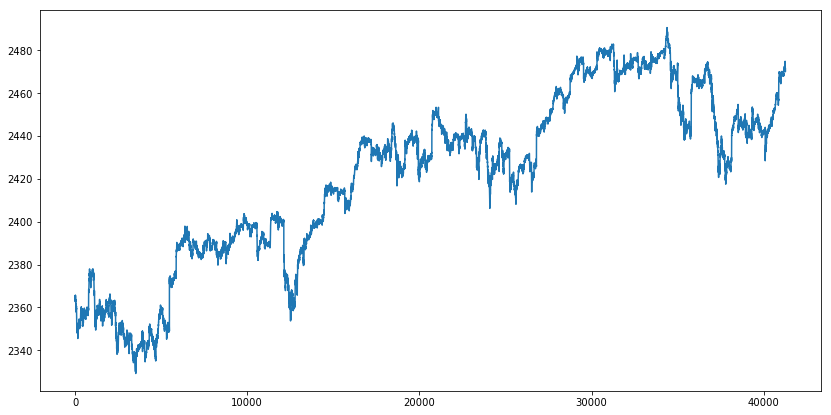

In [5]:
# time series plot of SP500
# visualization shows that there's dependence of stock price in time, as they shift 1 minute into the future

fig = plt.figure(figsize = (14, 7))
plt.plot(data[:, 0])

## NN

In [6]:
import tensorflow as tf

### Initializers

In [7]:
# Initializers
sigma = 1

# weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
weight_initializer = tf.contrib.layers.variance_scaling_initializer(mode = "FAN_AVG", uniform = True, dtype = tf.float32)


bias_initializer = tf.zeros_initializer()

### Architecture - Weights & Bias Parameter 

In [8]:
# Model architecture parameters

n_stocks = 500

n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128

n_target = 1

In [9]:
# Layer 1: Variables for hidden weights and biases
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

# Layer 2: Variables for hidden weights and biases
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

# Layer 3: Variables for hidden weights and biases
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))

# Layer 4: Variables for hidden weights and biases
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output layer: Variables for output weights and biases
W_out = tf.Variable(weight_initializer([n_neurons_4, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))


### Placeholder - Data

In [10]:
# Placeholder
# The None argument indicates that at this point the number of observations that flow through the neural net graph in each batch is not known yet, so it is kept flexible. 
# define the variable batch_size that controls the number of observations per training batch at a later stage.

X = tf.placeholder(dtype = tf.float32, shape = [None, n_stocks])
Y = tf.placeholder(dtype = tf.float32, shape = [None])


### Data and parameter together 

In [11]:
# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

# Output layer (must be transposed)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

### Cost function

In [12]:
# Cost function

mse = tf.reduce_mean(tf.squared_difference(out, Y))

### Optimizer

In [13]:
# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

## Train Test split 

In [14]:
# Train test split - 
# The training data ranges from April to approx. end of July 2017, the test data ends end of August 2017. 


train_start = 0
train_end = int(np.floor(0.8 * n))

test_start = train_end + 1
test_end = n

data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

In [15]:
# data scaling -
# most common activation functions of the network's neurons such as tanh or sigmoid are defined on the [-1, 1] or [0, 1]

# Scaling
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit(data_train)


# train test split first, scale the second on both
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [16]:
# Build feature matrix and target vector

X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]

## Fitting the NN

In [17]:
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68

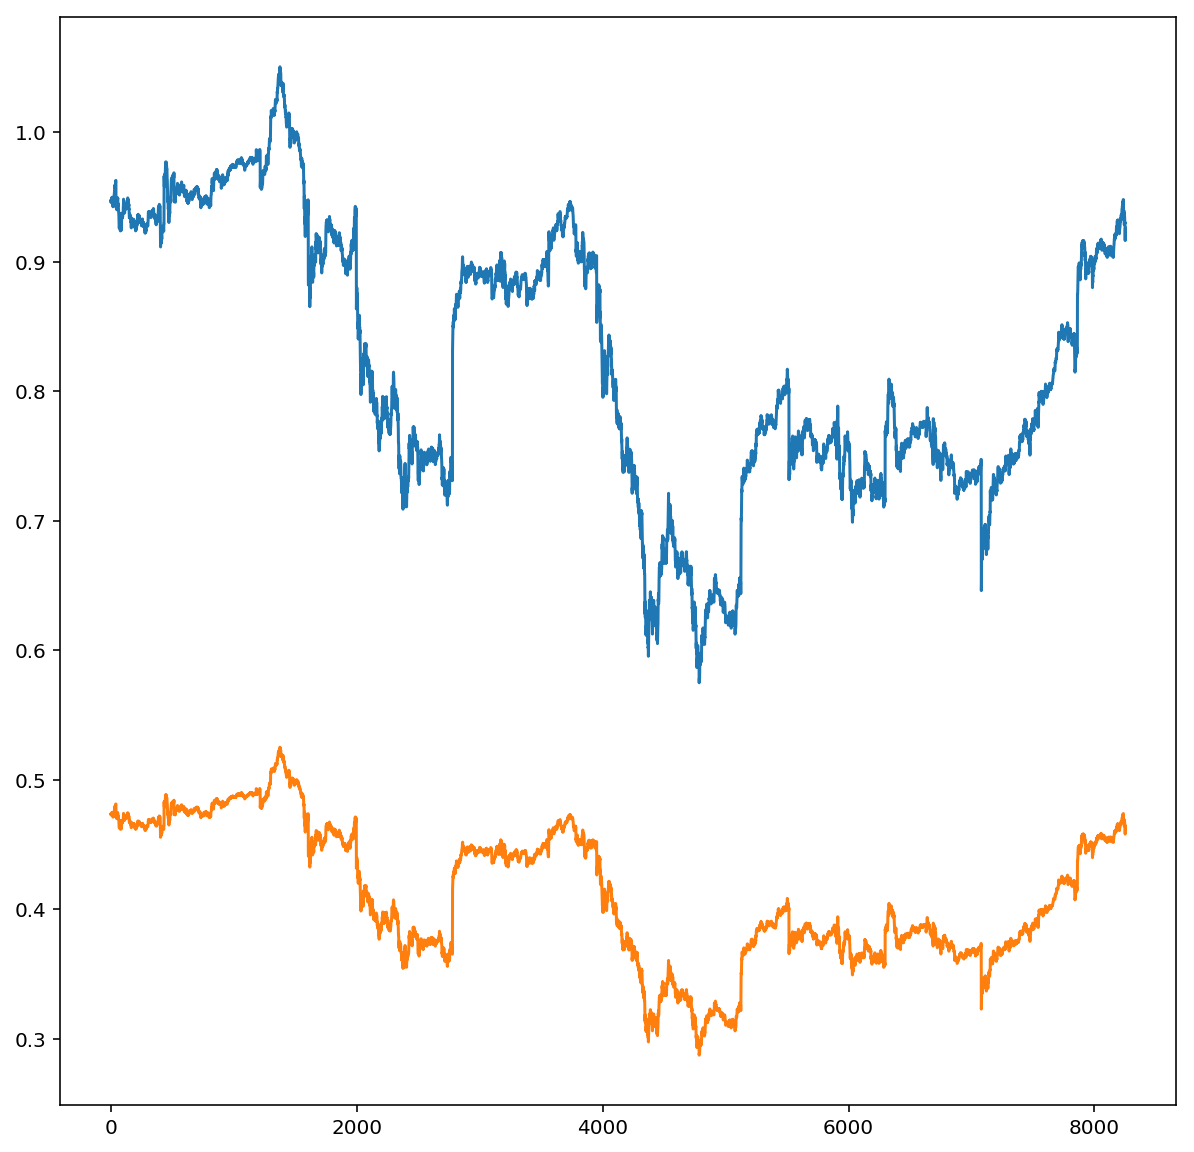

In [18]:
# Make Session
net = tf.Session()
# Run initializer
net.run(tf.global_variables_initializer())

# Setup interactive plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test * 0.5)
plt.show()

# Number of epochs and batch size
epochs = 10
batch_size = 256

for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict = {X: batch_x, Y: batch_y})

#         # Show progress
#         if np.mod(i, 5) == 0:
#             # Prediction
#             pred = net.run(out, feed_dict = {X: X_test})
#             line2.set_ydata(pred)
                
        print (i)
    
#             plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
#             file_name = 'img/epoch_' + str(e) + '_batch_' + str(i) + '.jpg'
#             plt.savefig(file_name)
#             plt.pause(0.01)


# Print final MSE after Training
mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})
print(mse_final)

In [21]:
pred = net.run(out, feed_dict = {X: X_test})
pred

array([[ 0.94447172,  0.94404578,  0.94364119, ...,  0.93840122,
         0.931023  ,  0.93695605]], dtype=float32)

In [23]:
# y_test

array([ 0.94704944,  0.94587856,  0.94789573, ...,  0.9164764 ,
        0.92597356,  0.92597356])

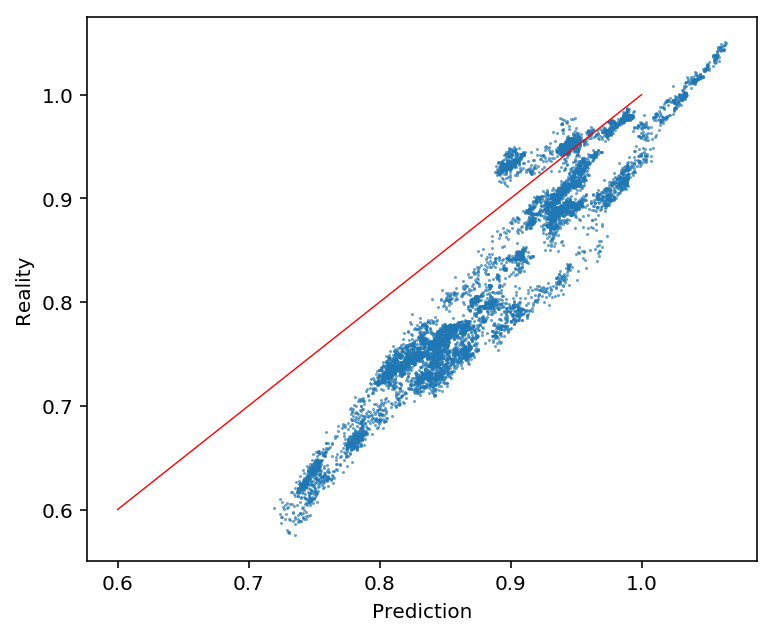

In [43]:
# visualize prediction and reality

fig = plt.figure(figsize = (6, 5))
plt.scatter(pred, y_test, marker = 'o', alpha = 0.7, s = 0.25)
plt.plot([0.6,1], [0.6,1], color = 'red', linewidth = 0.7)

plt.xlabel('Prediction')
plt.ylabel('Reality')

In [45]:
tf.summary.FileWriter